In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

sns.set_context("talk", font_scale=1.0)

In [15]:
# Directory containing the JSON files
directory_path = 'validate/'

# List to store the processed data
all_experiments = []

# Iterate through all JSON files in the directory
for file_path in glob.glob(os.path.join(directory_path, '*/metrics_*.json'), recursive=True):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract the model name from the file path
    model_name = os.path.basename(os.path.dirname(file_path)).split("_")[0]
    dataset_name = os.path.basename(file_path).split("_")[1].split(".")[0]
    
    for experiment in data['experiments']:
        # Flatten the dictionary to include metrics at the top level
        experiment_flat = {**experiment, **experiment.pop('metrics')}
        # Add the model name and dataset name to the experiment data
        experiment_flat['model'] = model_name
        experiment_flat['dataset'] = dataset_name
        # Append the processed experiment to the list
        all_experiments.append(experiment_flat)

# Create a DataFrame from the combined data
df = pd.DataFrame(all_experiments)
df.drop("metrics", axis="columns", inplace=True)



# Set iterations and epsilon to 0 where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'iterations'] = 0
df.loc[df['attack'] == 'none', 'epsilon'] = 0
# Replace 'epe_orig_preds' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_orig_preds'] = df['epe']
# Replace 'epe_ground_truth' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_ground_truth'] = df['epe']

# Get unique attack types excluding 'none'
attack_types = df['attack'].unique()
attack_types = attack_types[attack_types != 'none']

# Filter entries with attack == 'none'
none_entries = df[df['attack'] == 'none']

# Create copies of 'none' entries for each attack type
new_entries = []
for attack in attack_types:
    temp = none_entries.copy()
    temp['attack'] = attack
    new_entries.append(temp)

# Combine all new entries into a single DataFrame
new_entries_df = pd.concat(new_entries)

# Combine the new entries with the original DataFrame
result_df = pd.concat([df, new_entries_df])


# Keep only most recent results
# Convert 'start_time' to datetime
df['end_time'] = pd.to_datetime(df['end_time'])

# Sort the DataFrame by 'start_time'
df = df.sort_values(by='end_time')

# Drop duplicates, keeping the most recent entry for each combination of specified columns
unique_columns = ['model', 'checkpoint', 'attack', 'targeted', 'target', 'dataset', 'norm', 'epsilon', 'iterations', 'alpha', 'optim']
df = df.drop_duplicates(subset=unique_columns, keep='last')


# Replace optim=NaN with ground truth
df['optim'] = df['optim'].fillna("ground_truth")

# Replace ms with ms_raft+
df['model'] = df['model'].replace('ms', 'ms_raft+')


df.to_csv("big_df.csv")

In [16]:
# Directory containing the JSON files
directory_path = 'validate/'

# List to store the processed data
all_experiments = []

# Iterate through all JSON files in the directory
for file_path in glob.glob(os.path.join(directory_path, '*/iteration_metrics_*.json'), recursive=True):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract the model name from the file path
    model_name = os.path.basename(os.path.dirname(file_path)).split("_")[0]
    dataset_name = os.path.basename(file_path).split("_")[2].split(".")[0]
    
    for experiment in data['experiments']:
        # Flatten the dictionary to include metrics at the top level
        experiment_flat = {**experiment, **experiment.pop('metrics')}
        # Add the model name and dataset name to the experiment data
        experiment_flat['model'] = model_name
        experiment_flat['dataset'] = dataset_name
        # Append the processed experiment to the list
        all_experiments.append(experiment_flat)

# Create a DataFrame from the combined data
iterations_df = pd.DataFrame(all_experiments)
iterations_df.drop("metrics", axis="columns", inplace=True)

# Keep only most recent results
# Convert 'start_time' to datetime
iterations_df['end_time'] = pd.to_datetime(df['end_time'])

# Sort the DataFrame by 'start_time'
iterations_df = iterations_df.sort_values(by='end_time')

# Drop duplicates, keeping the most recent entry for each combination of specified columns
unique_columns = ['model', 'checkpoint', 'attack', 'targeted', 'target', 'dataset', 'norm', 'epsilon', 'iterations', 'alpha', 'optim']
iterations_df = iterations_df.drop_duplicates(subset=unique_columns, keep='last')

iterations_df["dataset"]

601       kitti-2015
602       kitti-2015
604       kitti-2015
605       kitti-2015
607       kitti-2015
            ...     
972     sintel-clean
973     sintel-clean
974     sintel-clean
1018    sintel-final
1019    sintel-final
Name: dataset, Length: 953, dtype: object

In [12]:
# Add i0 to the iterations dataframe
none_df = df[df['attack'] == 'none']

# Select only the necessary columns for the join
none_df = none_df[['model', 'checkpoint', 'dataset', 'epe', "epe_initial_to_negative", "epe_initial_to_zero"]]
none_df.rename(columns={'epe': 'epe_gt_i0'}, inplace=True)

none_df

,model,checkpoint,dataset,epe_gt_i0,epe_initial_to_negative,epe_initial_to_zero
4069,flownet2,/pfs/work7/workspace/scratch/ma_jcaspary-team_...,sintel-final,4.315705,NaN,NaN
4070,flownet2,/pfs/work7/workspace/scratch/ma_jcaspary-team_...,sintel-clean,3.062346,NaN,NaN
44,flownet2,things,sintel-clean,2.222159,NaN,NaN
3897,flownet2,/pfs/work7/workspace/scratch/ma_jcaspary-team_...,sintel-final,12.746139,NaN,NaN
3899,flownet2,/pfs/work7/workspace/scratch/ma_jcaspary-team_...,sintel-clean,12.364851,NaN,NaN
...,...,...,...,...,...,...
1141,rapidflow,sintel,sintel-clean,0.949425,26.554159,13.277079
3030,scopeflow,sintel,sintel-clean,1.614737,26.035527,13.017763
3944,llaflow,sintel,sintel-clean,0.554258,26.801387,13.400693
3933,starflow,sintel,sintel-clean,1.600120,25.716464,12.858232


In [17]:
# Perform the join operation to add `epe_i0` to `iterations_df`
iterations_df = pd.merge(iterations_df, none_df, on=['model', 'checkpoint', 'dataset'], how='left')

iterations_df['epe_target_i0'] = iterations_df.apply(
    lambda row: row['epe_initial_to_negative'] if row['target'] == 'negative' else row['epe_initial_to_zero'],
    axis=1
)

# Sort the dataframe by 'start_time' to ensure it remains ordered
iterations_df = iterations_df.sort_values(by='start_time')

# Replace optim=NaN with ground truth
iterations_df['optim'] = iterations_df['optim'].fillna("ground_truth")

# Replace ms with ms_raft+
iterations_df['model'] = iterations_df['model'].replace('ms', 'ms_raft+')

# Display the updated dataframe
#iterations_df.to_csv("iteration_df.csv")
iterations_df["dataset"]

869      kitti-2015
38       kitti-2015
242      kitti-2015
243      kitti-2015
245      kitti-2015
           ...     
726    sintel-clean
743    sintel-final
340    sintel-final
341    sintel-final
342    sintel-final
Name: dataset, Length: 953, dtype: object

In [62]:
# Create set colors for each model to use in graphs
model_names = df["model"].unique().tolist()
base_cmap = sns.color_palette('husl', n_colors=30)
colors = {model: base_cmap[i] for i, model in enumerate(model_names)}

#### BIM/PGD/CosPGD init flow as optimization target -- Kitti

[<matplotlib.lines.Line2D object at 0x1548881f5ff0>, <matplotlib.lines.Line2D object at 0x1548881f4cd0>, <matplotlib.lines.Line2D object at 0x1548881f6aa0>, <matplotlib.lines.Line2D object at 0x1548881f6d10>, <matplotlib.lines.Line2D object at 0x1548881f6f80>, <matplotlib.lines.Line2D object at 0x1548881f71f0>, <matplotlib.lines.Line2D object at 0x1548881f7460>, <matplotlib.lines.Line2D object at 0x1548881f76d0>, <matplotlib.lines.Line2D object at 0x1548881f7940>, <matplotlib.lines.Line2D object at 0x154883f47be0>, <matplotlib.lines.Line2D object at 0x154883f46f20>, <matplotlib.lines.Line2D object at 0x154883f45840>, <matplotlib.lines.Line2D object at 0x154883f6c820>, <matplotlib.lines.Line2D object at 0x154883f6c160>, <matplotlib.lines.Line2D object at 0x154883f6ceb0>, <matplotlib.lines.Line2D object at 0x154883f6d120>]
['gma', 'raft', 'scopeflow', 'flow1d', 'liteflownet3', 'flowformer++', 'ms_raft+', 'rpknet', 'maskflownet', 'gma', 'maskflownet', 'scopeflow', 'flow1d', 'craft', 'lite

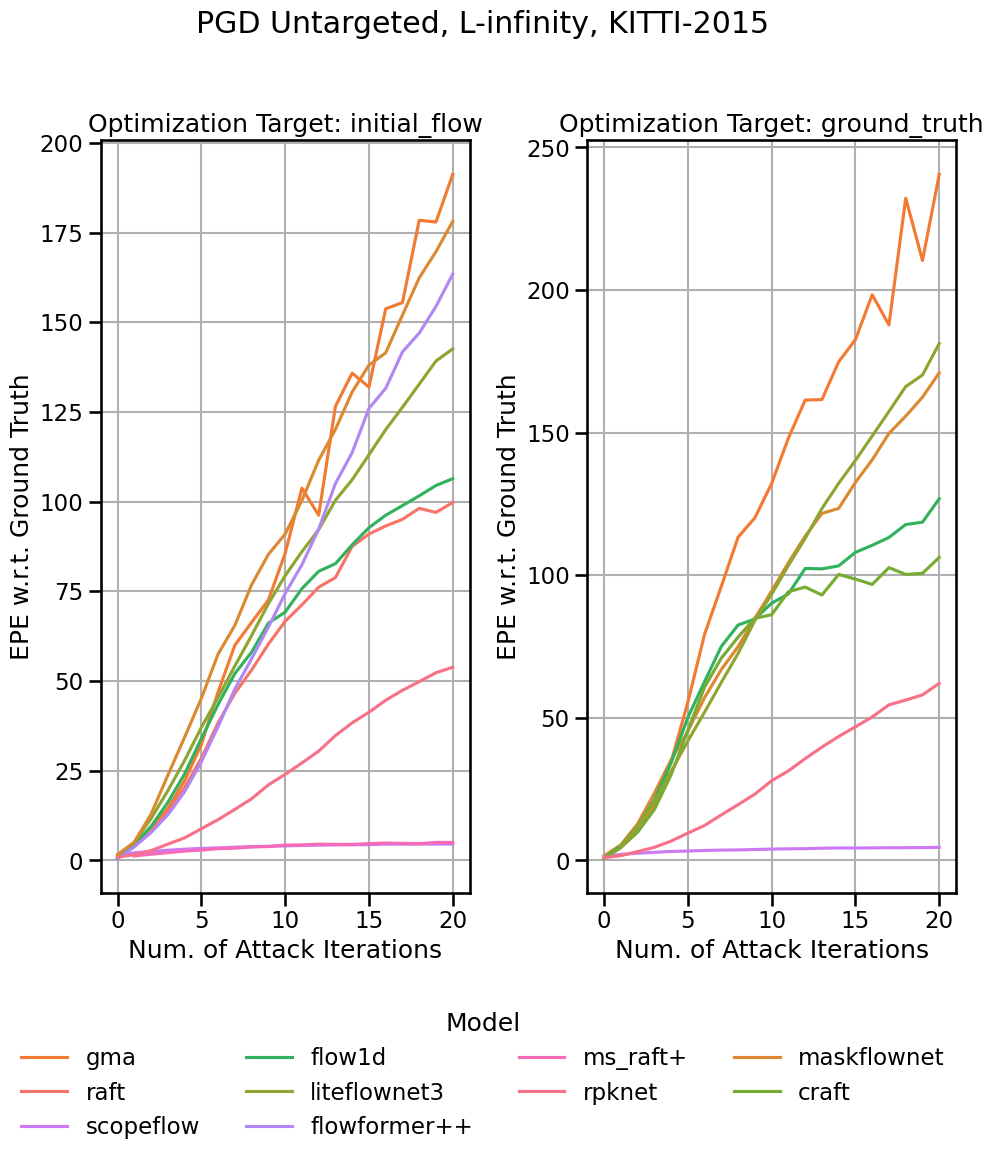

[<matplotlib.lines.Line2D object at 0x154883e5dd20>, <matplotlib.lines.Line2D object at 0x154883e858a0>, <matplotlib.lines.Line2D object at 0x154883e851e0>, <matplotlib.lines.Line2D object at 0x154883e84b20>, <matplotlib.lines.Line2D object at 0x154883e842e0>, <matplotlib.lines.Line2D object at 0x154883e85f30>, <matplotlib.lines.Line2D object at 0x154883e861a0>, <matplotlib.lines.Line2D object at 0x154883e86410>, <matplotlib.lines.Line2D object at 0x154883e86680>, <matplotlib.lines.Line2D object at 0x154883ef5420>, <matplotlib.lines.Line2D object at 0x154883ed7d00>, <matplotlib.lines.Line2D object at 0x154883ed6320>, <matplotlib.lines.Line2D object at 0x154883ef59f0>, <matplotlib.lines.Line2D object at 0x154883ef5060>, <matplotlib.lines.Line2D object at 0x154883ef49a0>]
['raft', 'maskflownet', 'scopeflow', 'flow1d', 'liteflownet3', 'flowformer++', 'ms_raft+', 'rpknet', 'gma', 'maskflownet', 'scopeflow', 'flow1d', 'craft', 'liteflownet3', 'rpknet']


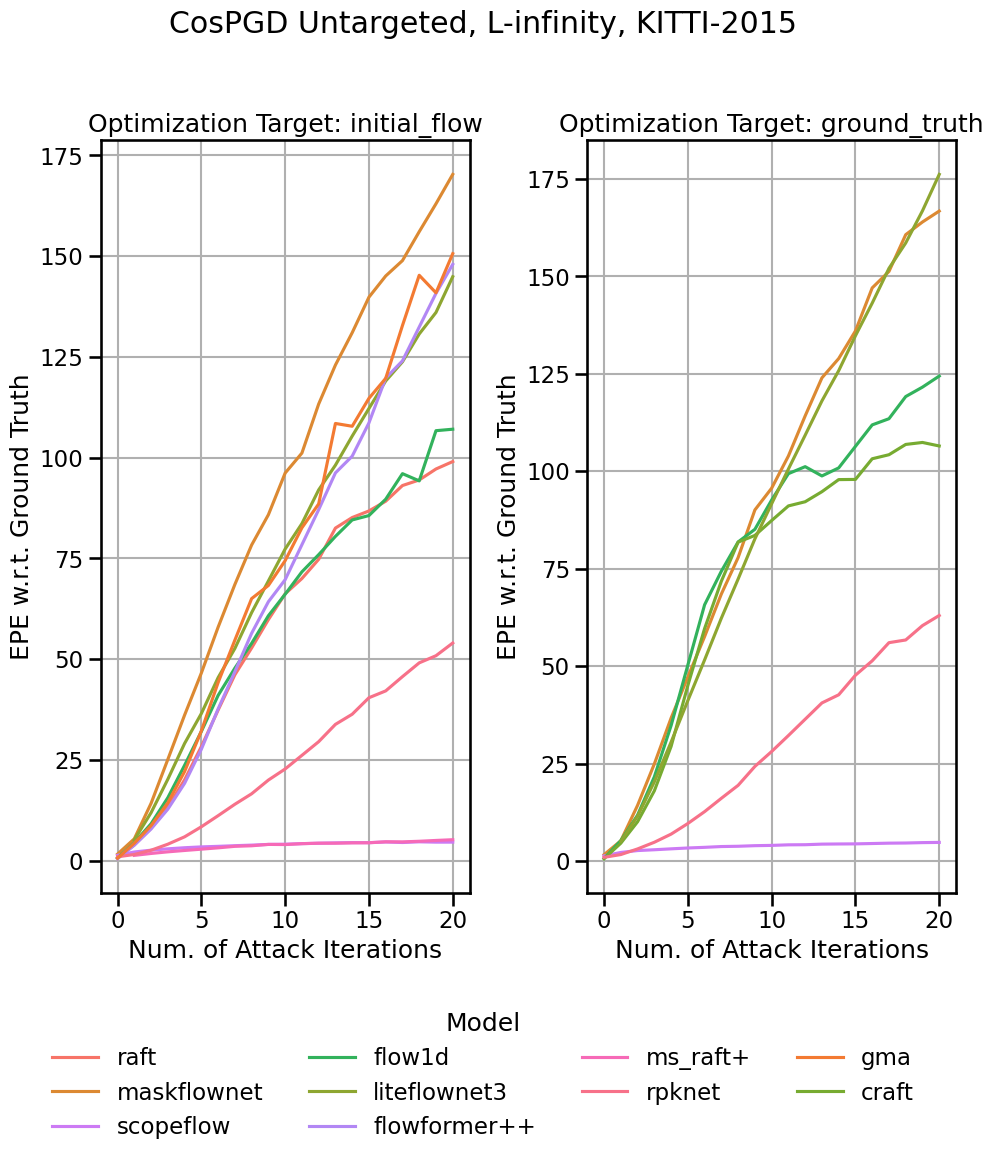

In [63]:
def plot(data, title, filename, optim_targets, model_palette):
    num_optim_target = len(optim_targets)
    fig, axes = plt.subplots(1, num_optim_target, figsize=(5 * num_optim_target, 10))
    fig.suptitle(title)

    if num_optim_target == 1:
        axes = [axes]

    # Define a color palette explicitly
    # unique_models = data['model'].unique()
    # palette = sns.color_palette("husl", len(unique_models))
    # model_palette = dict(zip(unique_models, palette))

    # Collect handles and labels for the legend
    handles, labels = [], []

    for ax, optim_target in zip(axes, optim_targets):
        # Filter the data for the current optimization target
        plot_data = data.query(f"optim == '{optim_target}' or epsilon == 0")
        # Create the line plot with consistent color mapping
        sns.lineplot(
            data=plot_data,
            x='iterations',
            y='epe',
            hue='model',
            palette=model_palette,  # Apply the predefined color palette
            ax=ax,
            errorbar=None
        )

        # Collect legend handles and labels from each plot
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

        ax.set_title(f'Optimization Target: {optim_target}')
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE w.r.t. Ground Truth')
        ax.grid(True)

    # Remove individual legends from each subplot
    for ax in axes:
        ax.legend_.remove()

    # Create a unique legend for the entire figure
    unique_handles_labels = dict(zip(labels, handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Adjust layout to fit title and legend
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'kitti-2015' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, KITTI-2015', 'graphs/PGD_kitti_init_flow.png', ["initial_flow", "ground_truth"], colors)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, KITTI-2015', 'graphs/CosPGD_kitti_init_flow.png', ["initial_flow", "ground_truth"], colors)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-clean

[<matplotlib.lines.Line2D object at 0x154883dca890>, <matplotlib.lines.Line2D object at 0x154883dcaf20>, <matplotlib.lines.Line2D object at 0x154883dcb190>, <matplotlib.lines.Line2D object at 0x154883dcb400>, <matplotlib.lines.Line2D object at 0x154883dcb670>, <matplotlib.lines.Line2D object at 0x154883dcb8e0>, <matplotlib.lines.Line2D object at 0x154883dcbb50>, <matplotlib.lines.Line2D object at 0x154883d6b760>, <matplotlib.lines.Line2D object at 0x154883dca6e0>, <matplotlib.lines.Line2D object at 0x154883c35a80>, <matplotlib.lines.Line2D object at 0x154883c09ae0>, <matplotlib.lines.Line2D object at 0x154883c0b400>, <matplotlib.lines.Line2D object at 0x154883c357b0>]
['scopeflow', 'gma', 'flowformer++', 'maskflownet', 'raft', 'flow1d', 'ms_raft+', 'liteflownet3', 'rpknet', 'gma', 'liteflownet3', 'raft', 'maskflownet']


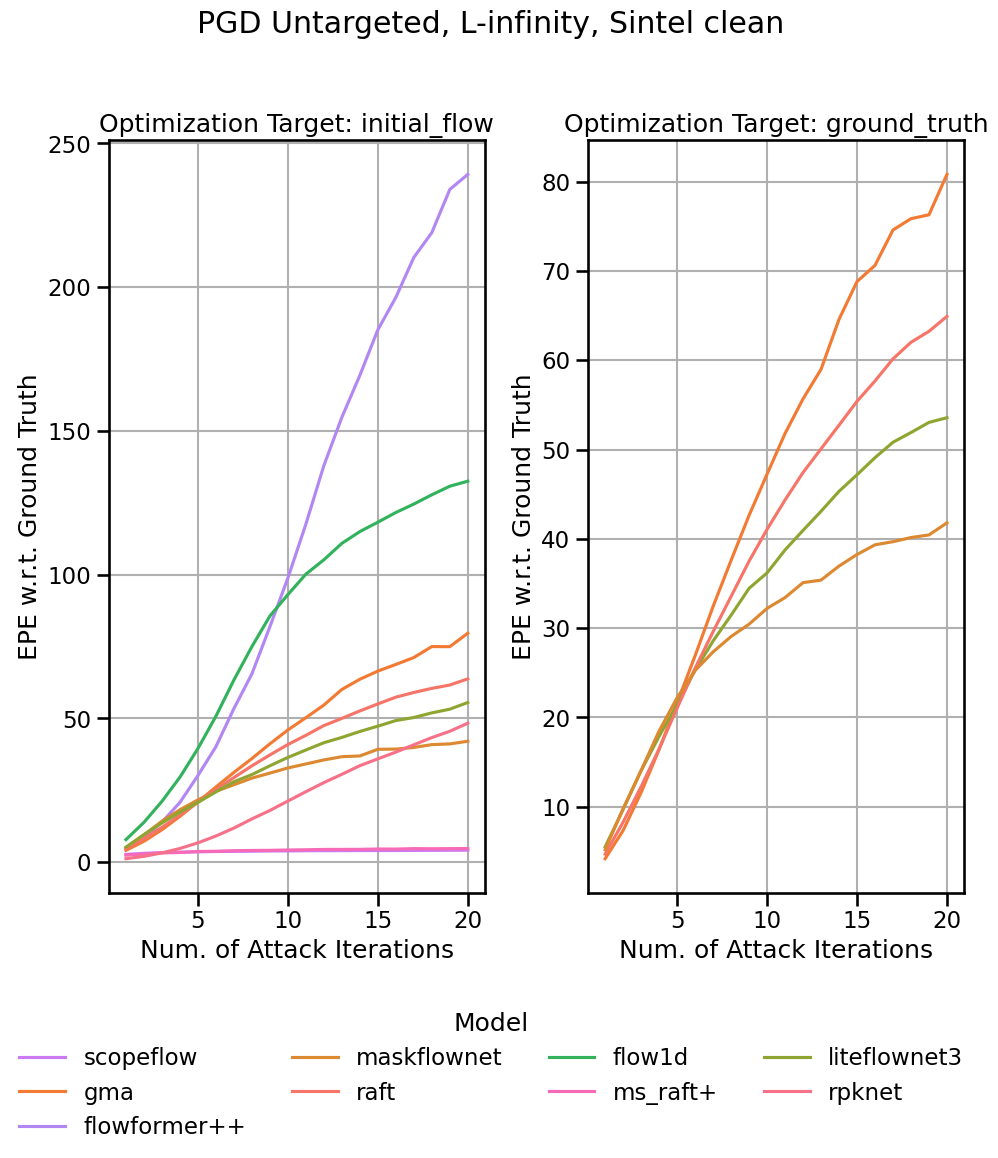

[<matplotlib.lines.Line2D object at 0x154883b40520>, <matplotlib.lines.Line2D object at 0x154883b406d0>, <matplotlib.lines.Line2D object at 0x154883b40940>, <matplotlib.lines.Line2D object at 0x154883b40bb0>, <matplotlib.lines.Line2D object at 0x154883b40e20>, <matplotlib.lines.Line2D object at 0x154883b41090>, <matplotlib.lines.Line2D object at 0x154883b41300>, <matplotlib.lines.Line2D object at 0x154883b41570>, <matplotlib.lines.Line2D object at 0x154883b417e0>, <matplotlib.lines.Line2D object at 0x154883b922c0>, <matplotlib.lines.Line2D object at 0x154883b92740>, <matplotlib.lines.Line2D object at 0x154883b929b0>, <matplotlib.lines.Line2D object at 0x154883ccde70>]
['scopeflow', 'gma', 'flowformer++', 'rpknet', 'maskflownet', 'raft', 'flow1d', 'ms_raft+', 'liteflownet3', 'gma', 'liteflownet3', 'raft', 'maskflownet']


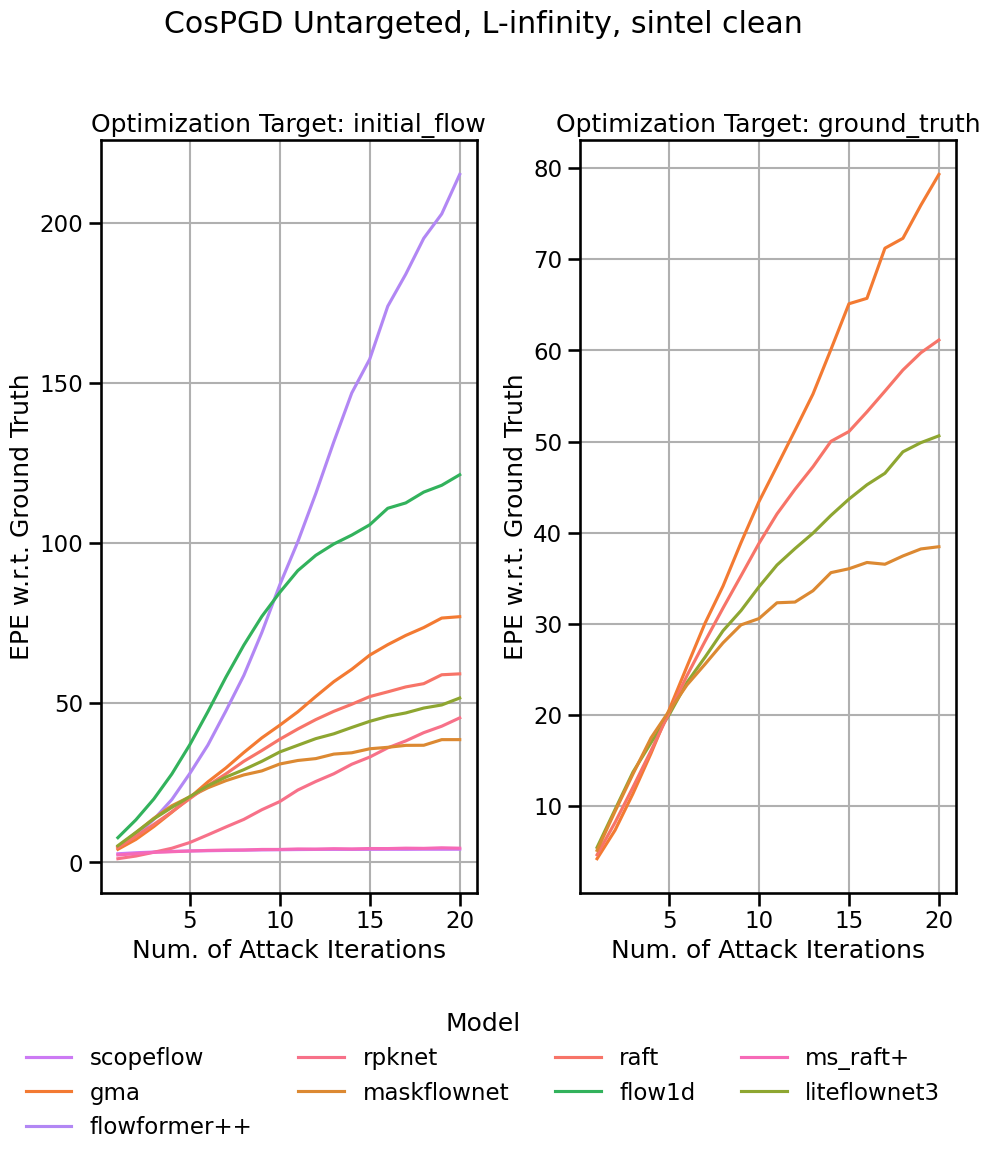

In [64]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, Sintel clean', 'graphs/PGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], colors)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, sintel clean', 'graphs/CosPGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], colors)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-final

[<matplotlib.lines.Line2D object at 0x154883a95360>, <matplotlib.lines.Line2D object at 0x154883a957e0>, <matplotlib.lines.Line2D object at 0x154883a95a50>, <matplotlib.lines.Line2D object at 0x154883a95cc0>, <matplotlib.lines.Line2D object at 0x154883a95f30>, <matplotlib.lines.Line2D object at 0x154883a6e3b0>, <matplotlib.lines.Line2D object at 0x154883a6fb20>, <matplotlib.lines.Line2D object at 0x154883a94e80>, <matplotlib.lines.Line2D object at 0x154883a947c0>, <matplotlib.lines.Line2D object at 0x154883aefcd0>, <matplotlib.lines.Line2D object at 0x154883aef040>, <matplotlib.lines.Line2D object at 0x154883aed750>, <matplotlib.lines.Line2D object at 0x154883aee0e0>, <matplotlib.lines.Line2D object at 0x1548839106d0>, <matplotlib.lines.Line2D object at 0x1548839109a0>, <matplotlib.lines.Line2D object at 0x154883910c10>, <matplotlib.lines.Line2D object at 0x154883910e80>]
['flowformer++', 'maskflownet', 'scopeflow', 'liteflownet3', 'flow1d', 'ms_raft+', 'raft', 'gma', 'rpknet', 'gma', 

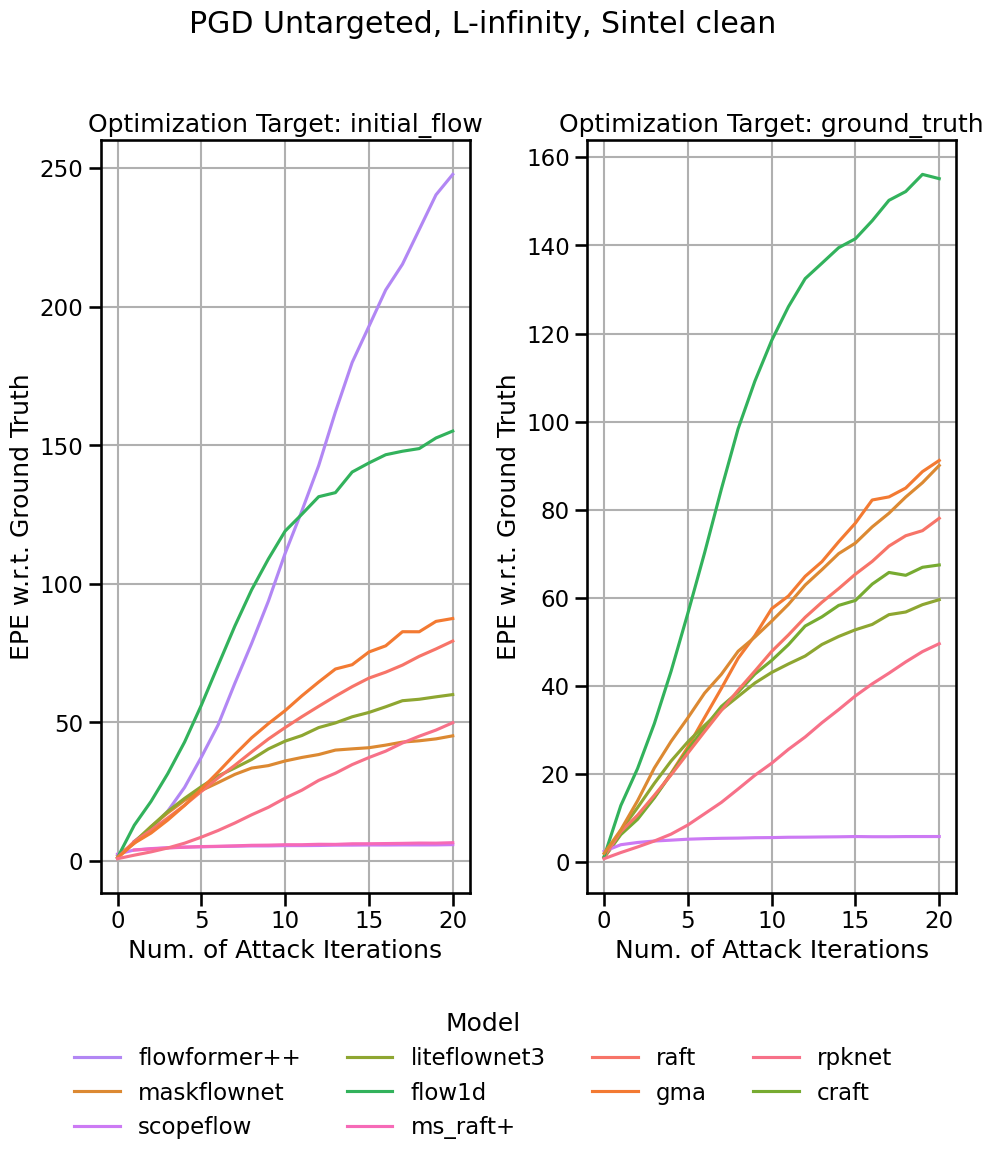

[<matplotlib.lines.Line2D object at 0x154883820400>, <matplotlib.lines.Line2D object at 0x154883820880>, <matplotlib.lines.Line2D object at 0x154883820af0>, <matplotlib.lines.Line2D object at 0x154883820d60>, <matplotlib.lines.Line2D object at 0x154883820fd0>, <matplotlib.lines.Line2D object at 0x154883821240>, <matplotlib.lines.Line2D object at 0x1548838214b0>, <matplotlib.lines.Line2D object at 0x1548839f96f0>, <matplotlib.lines.Line2D object at 0x1548839fa890>, <matplotlib.lines.Line2D object at 0x154883890160>, <matplotlib.lines.Line2D object at 0x154883890460>, <matplotlib.lines.Line2D object at 0x1548838906d0>, <matplotlib.lines.Line2D object at 0x154883890940>, <matplotlib.lines.Line2D object at 0x154883890bb0>, <matplotlib.lines.Line2D object at 0x15488386fc10>, <matplotlib.lines.Line2D object at 0x15488386f3d0>, <matplotlib.lines.Line2D object at 0x15488386d8d0>]
['gma', 'flowformer++', 'scopeflow', 'liteflownet3', 'flow1d', 'raft', 'ms_raft+', 'maskflownet', 'rpknet', 'craft'

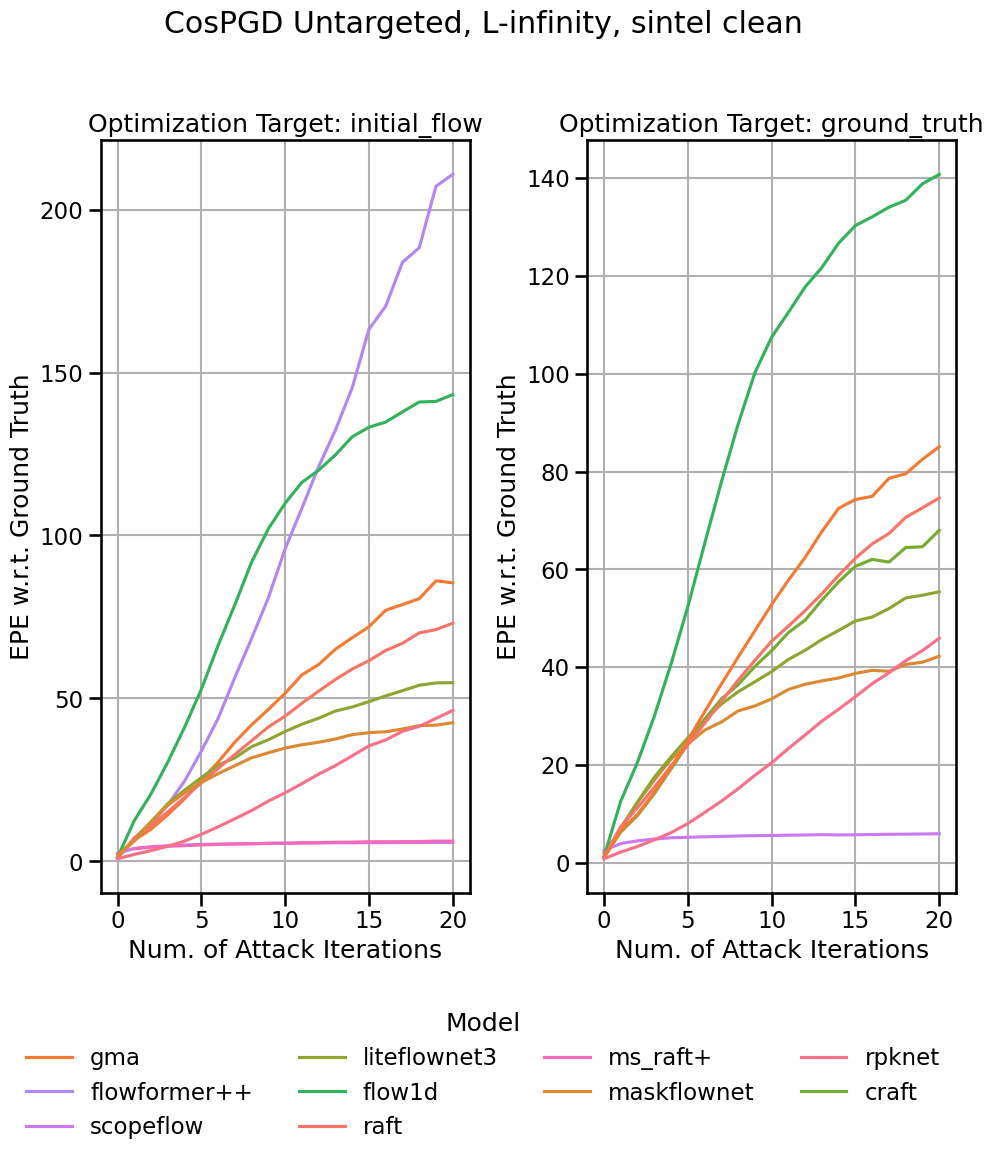

In [65]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-final' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, Sintel clean', 'graphs/PGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], colors)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, sintel clean', 'graphs/CosPGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], colors)
